# Logistic Regression #


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from skimage.transform import resize

np.set_printoptions(precision=2, suppress=True)
%matplotlib inline

***

## A. Preparing the dataset ##

A common pre-processing step in deep learning is to normalise the dataset. First, one computes the mean and standard deviation over the entire set. Then, the mean is subtracted from each item. Finally, data is scaled by the standard deviation. 

For image datasets, RGB pixel values are represented with 3 integers in the range of 0 to 255. A simpler pre-processing strategy that yields similar performance, is to divide each item by 255. 

Our dataset is stored in a single file called `catsvsnoncats.h5`. It is a collection of images labelled with ground truth information i.e. $y=1$ for the cat class and $y=0$ for the non-cat class. All images are of shape $(W, H, 3)$ where $W=H=64$ i.e. small square RGB images. Writing a function to load and preprocess the dataset such that each row represents an image whose pixels values are in the range (0,1). Our dataset is split in 2 sets, one for training and one for test.


In [2]:
def load_dataset(filepath='datasets/catsvsnoncats.h5'):
    """
    Load and pre-process dataset
    
    Arguments:
    filepath -- string, dataset path

    Returns:
    (X_train, Y_train), (X_test, Y_test), classes -- training and test datasets
    """

    h5file = h5py.File(filepath, "r")
    X_train = np.array(h5file["X_train"][:])
    X_test = np.array(h5file["X_test"][:])
    Y_train = np.array(h5file["Y_train"][:])
    Y_test = np.array(h5file["Y_test"][:])
    classes = np.array(h5file["Classes"][:]) 
    h5file.close()

    # Reshape and scale datasets containing N_train and N_test mages such that
    # X_train.shape = (n_train, W * H * 3)
    # X_test.shape = (n_test, W * H * 3)
    # Y_train.shape = (n_train, 1)
    # X_test.shape = (n_test, 1)
    # Scale X_train and X_test from range {0..255} to (0,1)
    
    X_train = X_train.reshape(X_train.shape[0],-1)/255
    X_test = X_test.reshape(X_test.shape[0],-1)/255
    Y_train = Y_train.reshape(-1,1)
    Y_test = Y_test.reshape(-1,1)

    return (X_train, Y_train), (X_test, Y_test), classes

In [3]:
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/catsvsnoncats.h5')
print("classes: 0={} 1={}".format(classes[0].decode(), classes[1].decode()))
print("sanity check: ({},{:.1f})".format(X_train[-1].min(),X_train[-1].max()))

classes: 0=not_cat 1=cat
sanity check: (0.0,1.0)


image class: not_cat


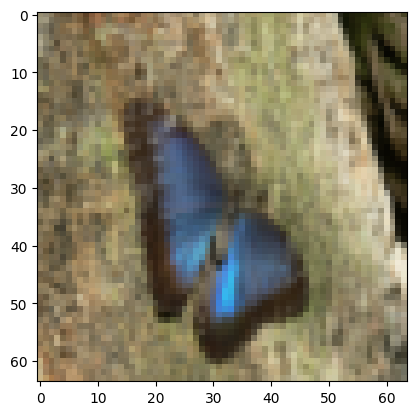

In [4]:
# Visualise a random picture from training set
import random
index = random.randint(0, Y_train.shape[0])
print("image class: {}".format(classes[int(Y_train[index, 0])].decode()))
_ = plt.imshow(X_train[index].reshape(64,64,3))

Many issues in deep learning can be resolved by inspecting tensor shapes, ensuring that matrices or vectors have appropriate dimensions.

***

Exploring dataset dimensions to understand the data structure.


In [5]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
feature_count = X_test.shape[1]

print("training set: {} images".format(n_train))
print("test set: {} images".format(n_test))
print("features per image: {} pixel values".format(feature_count))

training set: 209 images
test set: 50 images
features per image: 12288 pixel values


In [6]:
# Sigmoid vectorial function
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- scalar or numpy array of any size

    Returns:
    s -- sigmoid(x), scalar or numpy array of any size
    """
    
    s = 1/(1+np.exp(-x))
    return s

In [7]:
print("sigmoid([-1, 0, 1]) = {}".format(sigmoid(np.array([-1, 0,1]))))

sigmoid([-1, 0, 1]) = [0.27 0.5  0.73]


In [8]:
# Model parameter initialisation
def init_model_parameters(dim):
    """
    Initialise weights and bias to 0
    
    Argument:
    dim -- size of vector w (i.e. number of model parameters)
    
    Returns:
    w -- initialised weights: column vector of shape (dim, 1)
    b -- initialised bias: scalar
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [9]:
dim = 2
w, b = init_model_parameters(dim)
print("w.T = {}".format(w.T))
print("b = {}".format(b))

w.T = [[0. 0.]]
b = 0


In [10]:
# Forward propagation
def forward_prop(w, b, X, Y):
    """
    Compute the logistic regression loss and its gradient

    Arguments:
    w -- weight vector, a numpy array of shape (W * H * 3, 1)
    b -- bias, a scalar
    X -- n data samples (n, W * H * 3)
    Y -- ground truth vector (0=dog, 1=cat) of size (n, 1)

    Return:
    loss -- negative log-likelihood loss for logistic regression
    dw -- gradient of the loss with respect to w, same shape as w
    db -- gradient of the loss with respect to b, same shape as b
    """
    
    n = X.shape[0]
    
    # Forward prop: compute loss from (X, Y)
    Y_hat = sigmoid(np.dot(X,w)+b) # Compute Activation, shape (n, 1)
    loss = (-(1/n)*(Y.T@np.log(Y_hat)+(1-Y).T@np.log(1-Y_hat))) # Compute cross entropy loss (scalar)

    loss = np.squeeze(loss)
    assert(loss.shape == ())
    
    # Compute gradients for backprop
    dw = (X.T@(Y_hat-Y))/n
    db = (1/n)*np.sum(Y_hat-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)

    return {"dw": dw, "db": db}, loss

In [11]:
w, b, X, Y = np.array([[1., 2.]]).T, 2., np.array([[1., 2.], [3., -3.], [-2., -1.]]), np.array([[1,1,0]]).T
grads, loss = forward_prop(w, b, X, Y)
np.set_printoptions(precision=3, suppress=True)
print("dw.T = {}".format(grads["dw"].T))
print("db = {:.3f}".format(grads["db"]))
print("loss = {:.3f}".format(loss))

dw.T = [[-0.811  0.691]]
db = -0.204
loss = 0.480


In [12]:
# Parameter optimisation using backprop
def model_fit(w, b, X, Y, epochs, learning_rate):
    """
    Optimise w and b by performing gradient descent
    
    Arguments:
    w -- weight vector, a numpy array of shape (W * H * 3, 1)
    b -- bias, a scalar
    X -- n data samples (n, W * H * 3)
    Y -- ground truth vector (0=dog, 1=cat) of size (n, 1)
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    
    Returns:
    params -- dictionary with optimised weights and bias
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    loss_log = []
    for i in range(epochs):
        grads, loss = forward_prop(w, b, X, Y) # Cost and gradient computation
        dw = grads['dw'] # derivative from grads
        db = grads['db'] # derivative from grads
        w = w - learning_rate*dw # weights update
        b = b - learning_rate*db# bias update
        
        # logs
        if i % 100 == 0:
            loss_log.append(loss)
            print("Loss after {} iterations: {:.3f}".format(i, loss))
        
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, loss_log

In [13]:
params, grads, losses = model_fit(w, b, X, Y, epochs=800, learning_rate=0.008)
print("w.T = {}".format(params["w"].T))
print("b = {:.3f}".format(params["b"]))
print("dw.T = {}".format(grads["dw"].T))
print("db = {:.3f}".format(grads["db"]))

Loss after 0 iterations: 0.480
Loss after 100 iterations: 0.116
Loss after 200 iterations: 0.064
Loss after 300 iterations: 0.046
Loss after 400 iterations: 0.037
Loss after 500 iterations: 0.031
Loss after 600 iterations: 0.027
Loss after 700 iterations: 0.024
w.T = [[1.958 1.429]]
b = 2.110
dw.T = [[-0.05   0.011]]
db = 0.004


In [14]:
# Model inference
def model_predict(w, b, X):
    '''
    Predict class label using logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of shape (W * H * 3, 1)
    b -- bias, a scalar
    X -- n data samples (n, W * H * 3)
    
    Returns:
    Y_hat -- vector with class predictions for examples in X
    '''
    n = X.shape[0]

    A = (sigmoid(np.dot(X,w)+b)).reshape(n,-1) # Compute Activation, shape (n, 1)
    Y_hat = 1*(A >= 0.5) # Convert activations to {0,1} predictions
    
    assert(Y_hat.shape == (n, 1))    
    return Y_hat

In [15]:
w, b, X = np.array([[0.1, -0.2]]).T, 0.2, np.array([[1., 2], [3., -1.], [-2, -3]])
print("predictions.T = {}".format(model_predict(w, b, X).T))

predictions.T = [[0 1 1]]


In [16]:
# Logistic regression model
def logistic_regression_model(X_train, Y_train, X_test, Y_test, epochs=2000, learning_rate=0.5):
    '''
    Build, train and evalaute the logistic regression model
    
    Arguments:
    X_train -- training set a numpy array of shape (n_train, W * H * 3)
    Y_train -- training groud truth vector (0=dog, 1=cat) of size (n_train, 1)
    X_test -- testing set a numpy array of shape (n_test, W * H * 3)
    Y_test -- testing groud truth vector (0=dog, 1=cat) of size (n_test, 1)
    epochs -- number of iteration updates through dataset for training (hyperparameter)
    learning_rate -- learning rate of the gradient descent (hyperparameter)
    
    Returns:
    model -- dictionary with model parameters, training logs and testing results
    '''
    
    dim = X_train.shape[1]
    w, b = init_model_parameters(dim)
    params, grads, losses = model_fit(w, b, X_train, Y_train, epochs, learning_rate)
    Y_hat_train = model_predict(params['w'],params['b'],X_train)
    Y_hat_test = model_predict(params['w'],params['b'],X_test)

    print("{:.1f}% training acc.".format(100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))))
    print("{:.1f}% test acc.".format(100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))))
    
    model = {"w": params["w"], "b": params["b"], "losses": losses, "LR": learning_rate,
            "Y_hat_test": Y_hat_test, "Y_hat_train": Y_hat_train}
    
    return model

In [17]:
np.random.seed(2019)
model = logistic_regression_model(X_train, Y_train, X_test, Y_test, epochs=1000, learning_rate=0.005)

Loss after 0 iterations: 0.693
Loss after 100 iterations: 0.585
Loss after 200 iterations: 0.467
Loss after 300 iterations: 0.376
Loss after 400 iterations: 0.331
Loss after 500 iterations: 0.303
Loss after 600 iterations: 0.280
Loss after 700 iterations: 0.260
Loss after 800 iterations: 0.243
Loss after 900 iterations: 0.228
96.7% training acc.
72.0% test acc.


image class: cat
predicted class: not_cat


/tmp/ipykernel_867/4202498265.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("image class: {}".format(classes[int(Y_test[index, :])].decode()))
/tmp/ipykernel_867/4202498265.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("predicted class: {}".format(classes[int(model["Y_hat_test"][index, :])].decode()))


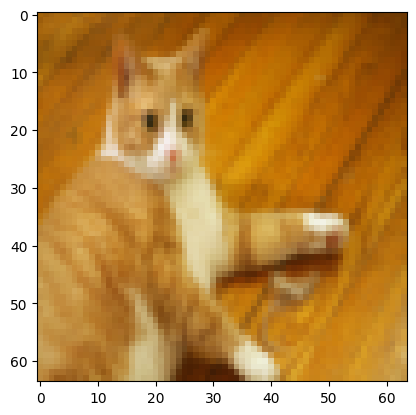

In [18]:
# Example of misclassification
misclassified_images = np.where(model["Y_hat_test"][:,-1] != Y_test[:,-1])[-1]
index = misclassified_images[random.randint(0, misclassified_images.shape[0] - 1)]

print("image class: {}".format(classes[int(Y_test[index, :])].decode()))
print("predicted class: {}".format(classes[int(model["Y_hat_test"][index, :])].decode()))
_ = plt.imshow(X_test[index].reshape(64,64,3))

It is also useful to monitor the logs of your traning sessions by plotting the loss as function of the epoch count. Observing how the loss decreases. If you increase the number of iterations, you could further increase training accuracy but at the cost of test accuracy which will start decreasing. This phenomenon is known as overfitting.


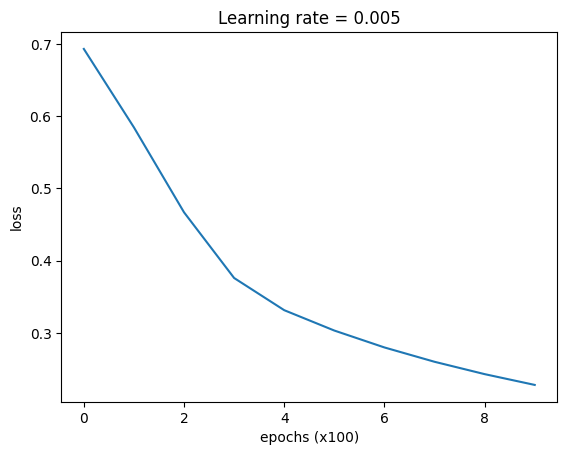

In [19]:
# Plot the learning curve
loss_logs = np.squeeze(model['losses'])
plt.plot(loss_logs)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(model['LR']))
plt.show()

Choosing hyperparameter values is often very important to achieve optimal performance for the model. In particular the learning rate $\lambda$ will determine how fast we may converge to the optimal parameter values. If $\lambda$ is too large, we may overshoot the optimal value resulting in poor perfomance while choosing a very small value can result in a slow algorithm. Experimenting with the training behaviours.


Loss after 0 iterations: 0.693
Loss after 100 iterations: 0.824
Loss after 200 iterations: 0.419
Loss after 300 iterations: 0.617
Loss after 400 iterations: 0.522
Loss after 500 iterations: 0.388
Loss after 600 iterations: 0.236
Loss after 700 iterations: 0.154
Loss after 800 iterations: 0.135
Loss after 900 iterations: 0.125
Loss after 1000 iterations: 0.116
Loss after 1100 iterations: 0.109
Loss after 1200 iterations: 0.103
Loss after 1300 iterations: 0.097
Loss after 1400 iterations: 0.092
Loss after 1500 iterations: 0.087
Loss after 1600 iterations: 0.083
Loss after 1700 iterations: 0.079
Loss after 1800 iterations: 0.076
Loss after 1900 iterations: 0.073
99.5% training acc.
70.0% test acc.
Loss after 0 iterations: 0.693
Loss after 100 iterations: 0.591
Loss after 200 iterations: 0.556
Loss after 300 iterations: 0.529
Loss after 400 iterations: 0.507
Loss after 500 iterations: 0.488
Loss after 600 iterations: 0.471
Loss after 700 iterations: 0.456
Loss after 800 iterations: 0.442
L

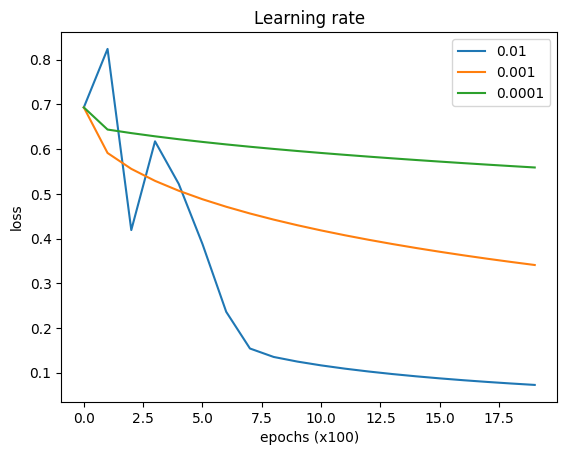

In [20]:
# Investigate other learning rates
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for lr in learning_rates:
    models[str(lr)] = logistic_regression_model(X_train, Y_train, X_test, Y_test, epochs=2000, learning_rate=lr)
    plt.plot(np.squeeze(models[str(lr)]["losses"]), label= str(models[str(lr)]["LR"]))
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.legend(loc='upper right')
plt.title("Learning rate")
plt.show()

Our logistic regression model performs quite well on this small dataset. However our classification problem is simple ; amoung natural images, cats have some distinctive features that can form some strong indicators for our classifier. Now I'll see how our model performs on a larger dataset of images of only dogs and cats. Running the code to observe how the performance drops significantly (this may take a few minutes to complete). Our model is too simple to achieve good performance. A well trained deep convolutional neural network would typically achieve a testing accuracy in the high nineties.


Loss after 0 iterations: 0.693
Loss after 100 iterations: 2.165
Loss after 200 iterations: 2.030
Loss after 300 iterations: 1.940
Loss after 400 iterations: 1.875
Loss after 500 iterations: 1.824
Loss after 600 iterations: 1.781
Loss after 700 iterations: 1.742
Loss after 800 iterations: 1.706
Loss after 900 iterations: 1.673
Loss after 1000 iterations: 1.642
Loss after 1100 iterations: 1.613
Loss after 1200 iterations: 1.585
Loss after 1300 iterations: 1.559
Loss after 1400 iterations: 1.534
Loss after 1500 iterations: 1.510
Loss after 1600 iterations: 1.487
Loss after 1700 iterations: 1.466
Loss after 1800 iterations: 1.445
Loss after 1900 iterations: 1.424
Loss after 2000 iterations: 1.405
Loss after 2100 iterations: 1.386
Loss after 2200 iterations: 1.367
Loss after 2300 iterations: 1.350
Loss after 2400 iterations: 1.332
Loss after 2500 iterations: 1.315
Loss after 2600 iterations: 1.298
Loss after 2700 iterations: 1.282
Loss after 2800 iterations: 1.266
Loss after 2900 iterations

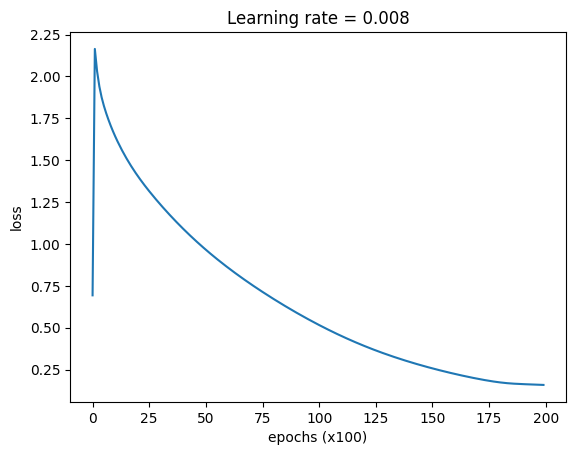

In [21]:
# Experiment with a more challenging dataset: dogs vs. cats
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/dogsvscats.h5')
model = logistic_regression_model(X_train, Y_train, X_test, Y_test, 
                                  epochs=20000, learning_rate=0.008)

# Plot the learning curve
loss_logs = np.squeeze(model['losses'])
plt.plot(loss_logs)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(model['LR']))
plt.show()